<a href="https://colab.research.google.com/github/ASDE-2023/RHBTouchHeart-Python/blob/main/Paynet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Read JSON File") \
    .getOrCreate()

# Read JSON file
df = spark.read.json("/content/cc_sample_transaction.json")

# Show schema
df.printSchema()

# Show data
df.show(truncate=False)


root
 |-- Unnamed: 0: string (nullable = true)
 |-- _corrupt_record: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- personal_detail: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)

+----------+---------------+------+-------------+-----------+-------------------+--------+----------------+----------------------+------------------+------------------+-------------+----------------------------------------+----------------------------------------------------------------------------------

In [8]:
category_counts = df.groupBy("category").count()


In [9]:
category_pd = category_counts.toPandas()


In [11]:
from pyspark.sql.functions import col

# Filter out null categories
category_counts = df.filter(col("category").isNotNull()) \
                    .groupBy("category") \
                    .count()


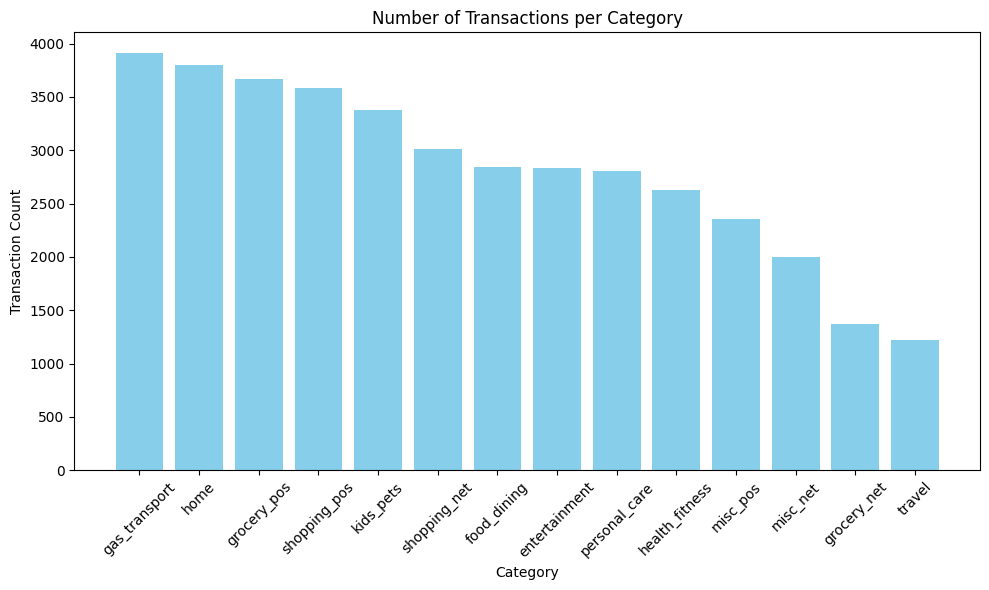

In [12]:
# Convert to pandas
category_pd = category_counts.toPandas()

# Sort
category_pd = category_pd.sort_values(by="count", ascending=False)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(category_pd['category'], category_pd['count'], color='skyblue')
plt.xlabel('Category')
plt.ylabel('Transaction Count')
plt.title('Number of Transactions per Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
from pyspark.sql.functions import col, from_json, split
from pyspark.sql.types import StructType, StructField, StringType

# Define schema for personal_detail
personal_detail_schema = StructType([
    StructField("person_name", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("address", StringType(), True),
    StructField("lat", StringType(), True),
    StructField("long", StringType(), True),
    StructField("city_pop", StringType(), True),
    StructField("job", StringType(), True),
    StructField("dob", StringType(), True)
])

# Parse personal_detail JSON string
df_parsed = df.withColumn("personal_json", from_json(col("personal_detail"), personal_detail_schema))

# Split person_name into first, last
df_parsed = df_parsed.withColumn("first", split(col("personal_json.person_name"), ",").getItem(0)) \
                     .withColumn("last", split(col("personal_json.person_name"), ",").getItem(1)) \
                     .withColumn("gender", col("personal_json.gender")) \
                     .withColumn("lat", col("personal_json.lat")) \
                     .withColumn("long", col("personal_json.long")) \
                     .withColumn("city_pop", col("personal_json.city_pop")) \
                     .withColumn("job", col("personal_json.job")) \
                     .withColumn("dob", col("personal_json.dob"))

# Define schema for nested address JSON
address_schema = StructType([
    StructField("street", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zip", StringType(), True)
])

# Parse address field
df_parsed = df_parsed.withColumn("address_json", from_json(col("personal_json.address"), address_schema)) \
                     .withColumn("street", col("address_json.street")) \
                     .withColumn("city", col("address_json.city")) \
                     .withColumn("state", col("address_json.state")) \
                     .withColumn("zip", col("address_json.zip"))


In [14]:
df_final = df_parsed.select(
    "Unnamed: 0", "trans_date_trans_time", "cc_num", "merchant", "category", "amt",
    "first", "last", "gender", "street", "city", "state", "zip", "lat", "long", "city_pop",
    "job", "dob", "trans_num", "merch_lat", "merch_long", "is_fraud",
    "merch_zipcode", "merch_last_update_time", "merch_eff_time", "cc_bic"
)


In [15]:
from pyspark.sql.functions import col, avg

# Convert amt to float if it's string
df_clean = df_parsed.withColumn("amt", col("amt").cast("float"))

# Average transaction amount by job
job_avg_amt = df_clean.groupBy("job").agg(avg("amt").alias("avg_amt"))

# Keep top 10 by highest average
top10_jobs = job_avg_amt.orderBy(col("avg_amt").desc()).limit(10)

# Convert to Pandas for plotting
top10_pd = top10_jobs.toPandas()


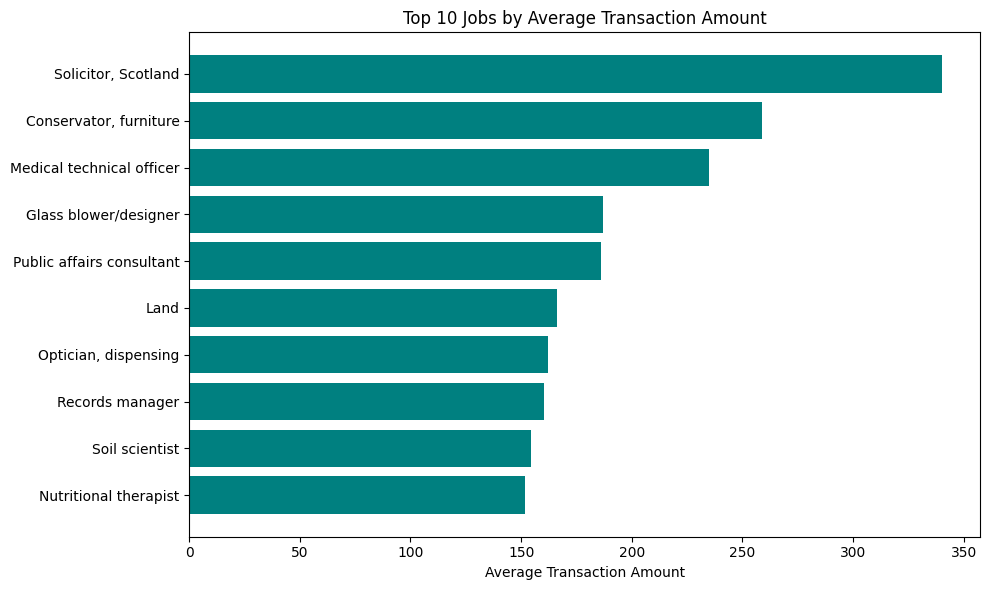

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(top10_pd['job'], top10_pd['avg_amt'], color='teal')
plt.xlabel('Average Transaction Amount')
plt.title('Top 10 Jobs by Average Transaction Amount')
plt.gca().invert_yaxis()  # So highest is at top
plt.tight_layout()
plt.show()


In [17]:
from pyspark.sql.functions import to_timestamp

df_with_timestamp = df.withColumn("trans_date_trans_time",
                                  to_timestamp("trans_date_trans_time", "yyyy-MM-dd HH:mm:ss"))


In [18]:
df_with_timestamp.select("trans_date_trans_time").printSchema()
df_with_timestamp.select("trans_date_trans_time").show(5, truncate=False)


root
 |-- trans_date_trans_time: timestamp (nullable = true)

+---------------------+
|trans_date_trans_time|
+---------------------+
|2019-01-01 00:00:18  |
|2019-01-01 00:00:44  |
|2019-01-01 00:00:51  |
|2019-01-01 00:01:16  |
|2019-01-01 00:03:06  |
+---------------------+
only showing top 5 rows



In [19]:
df_final.show(3, truncate=False)


+----------+---------------------+----------------+-------------------------------+-------------+------+--------------+-----+------+----------------------------+--------------+-----+-----+-------+---------+--------+---------------------------------+----------+--------------------------------+------------------+-----------+--------+-------------+----------------------+----------------+-----------+
|Unnamed: 0|trans_date_trans_time|cc_num          |merchant                       |category     |amt   |first         |last |gender|street                      |city          |state|zip  |lat    |long     |city_pop|job                              |dob       |trans_num                       |merch_lat         |merch_long |is_fraud|merch_zipcode|merch_last_update_time|merch_eff_time  |cc_bic     |
+----------+---------------------+----------------+-------------------------------+-------------+------+--------------+-----+------+----------------------------+--------------+-----+-----+-------+----

In [28]:
df_masked = df_final.withColumn(
    "city_masked",
    concat(
        substring("city", 1, 1),  # Keep first character
        lit("*") * (length("city") - 1)  # Fill remaining with asterisks
    )
)

In [29]:
df_masked.show(2)

+----------+---------------------+----------------+--------------------+-----------+------+---------+-----+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+------------------+-----------+--------+-------------+----------------------+----------------+-----------+-----------+
|Unnamed: 0|trans_date_trans_time|          cc_num|            merchant|   category|   amt|    first| last|gender|              street|          city|state|  zip|    lat|     long|city_pop|                 job|       dob|           trans_num|         merch_lat| merch_long|is_fraud|merch_zipcode|merch_last_update_time|  merch_eff_time|     cc_bic|city_masked|
+----------+---------------------+----------------+--------------------+-----------+------+---------+-----+------+--------------------+--------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+------------------+-----------+-----

In [31]:
from pyspark.sql.functions import regexp_replace

df_masked = df_final.withColumn(
    "city_masked",
    regexp_replace(col("city"), "(?<=.).", "*")  # Replace all chars after first with *
)

In [32]:
df_masked.select("city", "city_masked").show()

+--------------------+--------------------+
|                city|         city_masked|
+--------------------+--------------------+
|      Moravian Falls|      M*************|
|              Orient|              O*****|
|          Malad City|          M*********|
|             Boulder|             B******|
|            Doe Hill|            D*******|
|              Dublin|              D*****|
|             Holcomb|             H******|
|            Edinburg|            E*******|
|               Manor|               M****|
|         Clarksville|         C**********|
|            Clarinda|            C*******|
| Shenandoah Junction| S******************|
|    Saint Petersburg|    S***************|
|             Grenada|             G******|
|High Rolls Mounta...|H****************...|
|     Harrington Park|     H**************|
|              Lahoma|              L*****|
|            Carlisle|            C*******|
|         Harborcreek|         H**********|
|           Elizabeth|          